In [1]:
from astropy.coordinates import SkyCoord
from regions import Regions, CircleSkyRegion
from selectSIAF import defineApertures, getVertices, computeStcsFootprint, computeRegionFootprint
from getCatalog import gsss_stcsSearchUrl
from astropy.io import fits, votable
from astropy.wcs import WCS
from astropy.nddata.utils import Cutout2D
import astropy.units as u
import matplotlib.colors as colors
import cmasher as cms
from tqdm import tqdm

import matplotlib.pyplot as plt
import pysiaf
from matplotlib import rc

rc('text', usetex=True)
rc('font', **{'family': 'serif'})

## Select a Telescope, Instrument, and Aperture
In order to display a fooprint, we must first select three criteria:
1. Telescope. This must be a telescope with data in [pysiaf](https://pysiaf.readthedocs.io/en/stable/index.html); at present, this is HST, JWST, and Roman.
2. Instrument. The instrument used for the observation. The valid acronyms are listed in code comments in the cell below.
3. Aperture. For a full list of valid apertures, see the instrument documentation:
    - [HST User Documentation Homepage](https://hst-docs.stsci.edu)
    - [JWST MIRI Homepage](https://jwst-docs.stsci.edu/jwst-mid-infrared-instrument) (JWST has no instrument homepage; use the site navigation to reach other instrument pages)
    - [Roman Instruments Homepage](https://roman-docs.stsci.edu/roman-instruments-home)

### Example: Roman WFI
In the code cell below, we'll set some variables to hold these three selections. In this example, we're going to plot all 18 apertures from the Roman Space Telescope's Wide Field Instrument.

For completeness, examples for HST and JWST are available but commented out.

In [2]:
# define telescope, instrument, and aperture

selectedTelescope = 'roman'
selectedInstrument = 'WFI'      # Allowed options ALL, WFI, CGI
selectedAperture = 'ALL'        # Allowed options ALL or individual apertures listed in instrument documentation

# selectedTelescope = 'hst'
# selectedInstrument = 'ALL'     # Allowed options ALL, ACS, COS, FGS, NICMOS, STIS, WFC3
# selectedAperture = 'ALL'       # Allowed options ALL or individual apertures listed in instrument documentation

# selectedTelescope = 'jwst'
# selectedInstrument = 'ALL'     # Allowed options ALL, FGS, MIRI, NIRCAM, NIRSPEC, NIRISS
# selectedAperture = 'ALL'       # Allowed options ALL or individual apertures listed in instrument documentation

## Configure Apertures, Telescope Coordinate System

To simplify this Notebook, the `defineApertures` function from `selectSIAF` is essentially a lookup table, translating user-friendly instrument names into the correct corresponding apertures. 

This same function also generates the correct `V2Ref` and `V3Ref` offset angles. These V2/V3 values answer the question "what angles are there between this instrument and the line-of-sight of the telescope?". This is quite useful since, barring a catastrophic event, the instruments do not change their alignment relative to the line-of-sight.


In [3]:
# Set up aperture list and reference coordinates
apertureList, V2Ref, V3Ref = defineApertures(selectedTelescope, selectedInstrument, selectedAperture)

### Optional: Plot Footprint in Telescope Frame

Although not necessary to generate the final image, it is possible to plot the telescope apertures. We'll be plotting in a coordinate system that uses the telescope's pointing direction as (0,0); because of this, we don't need information about the celestial target or roll angle.

*Note: labels are useful for Roman WFI, but may be cluttered for other missions. You can toggle them off by setting `label=False` below.*

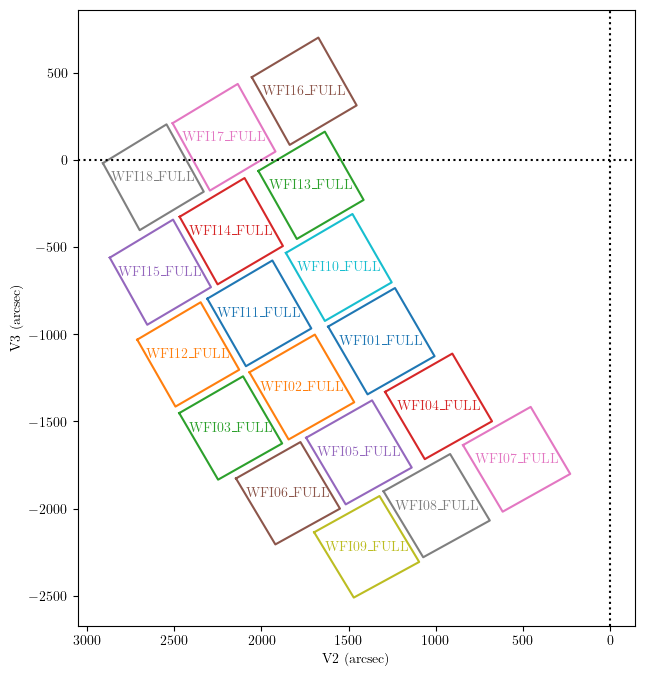

In [4]:
# OPTIONAL : set up plot of apertures (only works for QUAD, RECT, PICK aperture shapes)

# Set up the figure
plt.figure(figsize=(8, 8), facecolor='w', edgecolor='k')
plt.gca().invert_xaxis()

# iterate through apertures, then plot
for aperture in apertureList:
    # circles are not properly plotted, skip
    if aperture.AperShape != 'CIRC':
        # set labels=False to remove them
        aperture.plot(label=True)

# Add guide lines for boresight (V2, V3) = (0, 0)
plt.axvline(color='k', linestyle=":")
plt.axhline(color='k', linestyle=":")

# Display the plot
plt.show() 

100%|███████████████████████████████████████████████████████████████████████████| 20931/20931 [01:23<00:00, 250.38it/s]


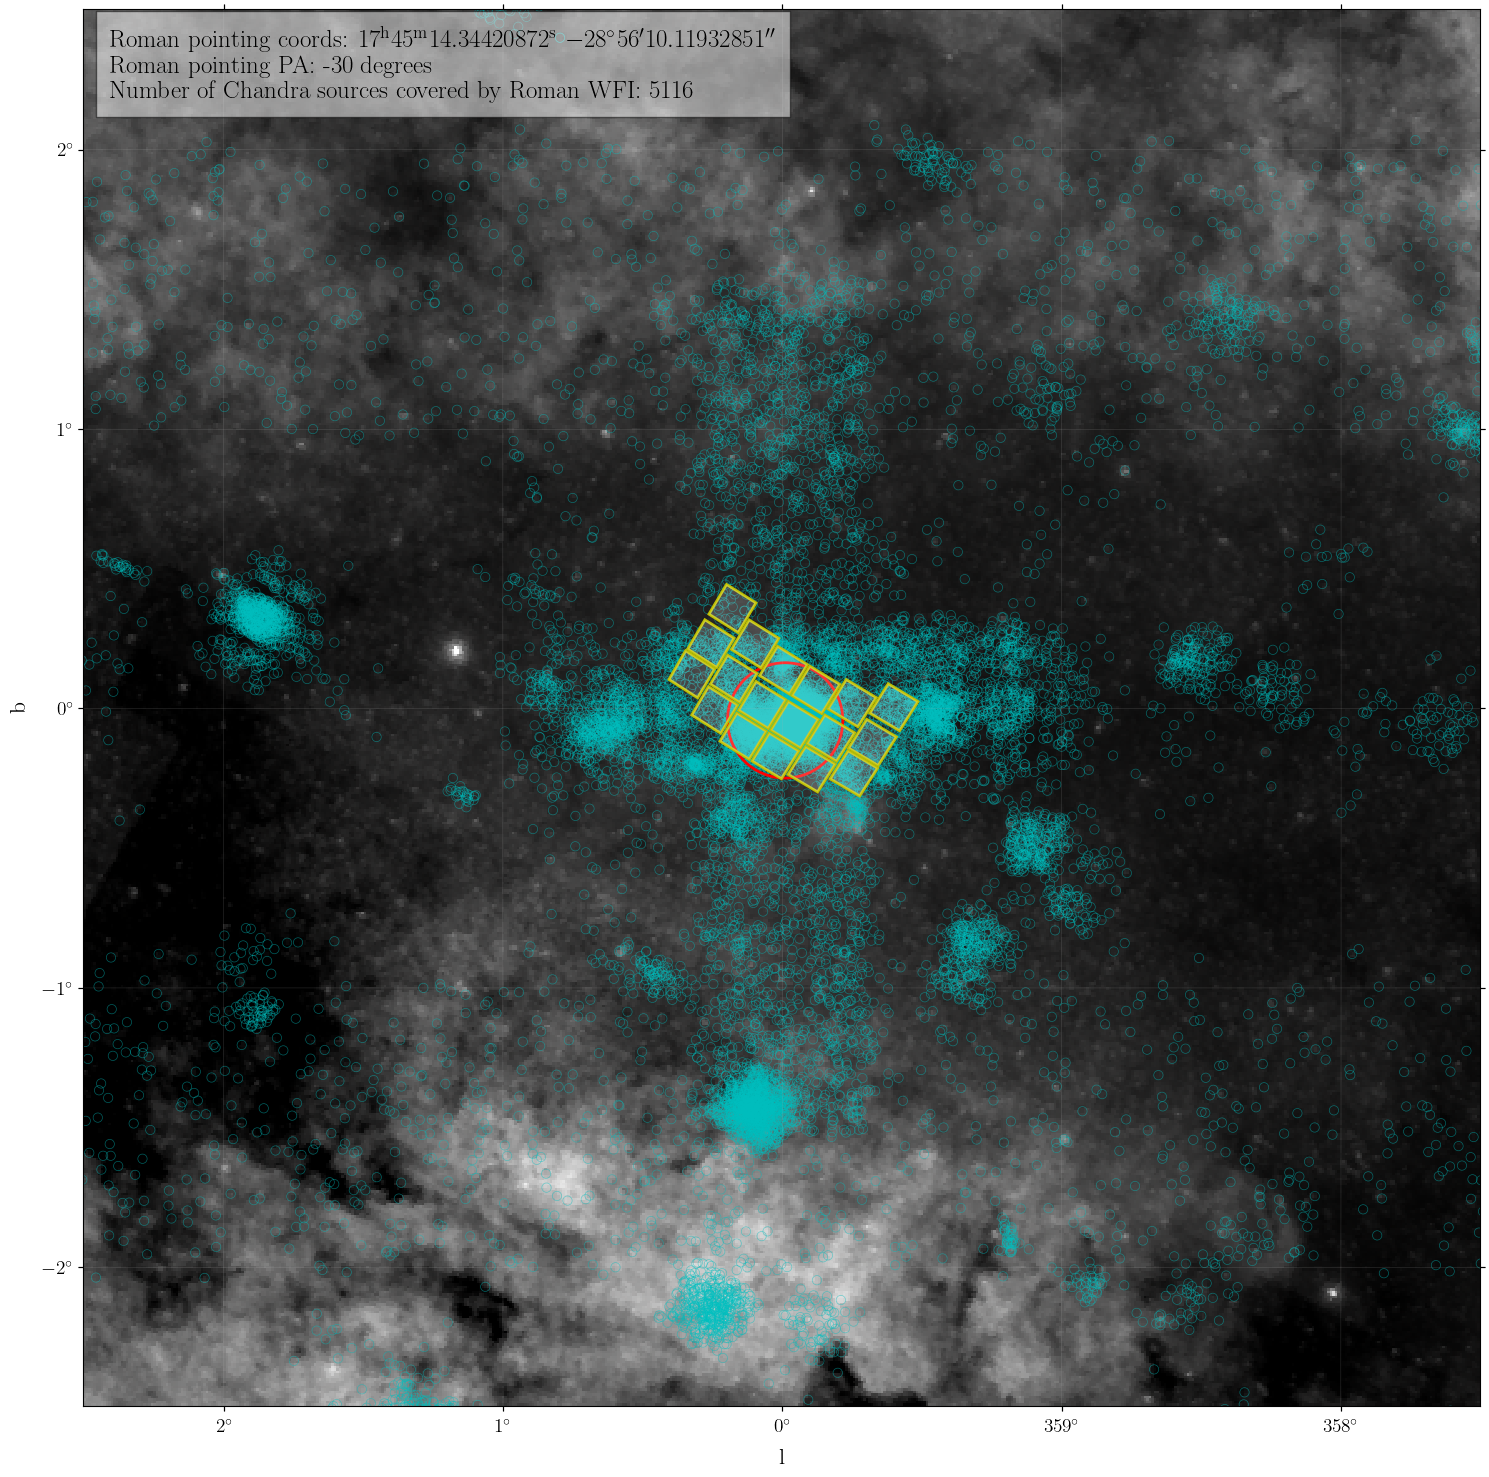

In [5]:
def roman_region_maker(coords, telescopePositionAngle):
    # get the values for SIAF
    targetRa = coords.ra
    targetDec = coords.dec
    attmat = pysiaf.utils.rotations.attitude_matrix(V2Ref, V3Ref, targetRa, targetDec, telescopePositionAngle)

    # Loop through aperture list  (only works for QUAD, RECT, CIRC aperture shapes)

    regionList = []
    for i in range(len(apertureList)):
        apertureSiaf = apertureList[i]
        apertureSiaf.set_attitude_matrix(attmat)
        xVertices, yVertices = getVertices(apertureSiaf)

        # Skip PICK which do not have vertices
        if (xVertices is not None and yVertices is not None):
            skyRa, skyDec = apertureSiaf.idl_to_sky(xVertices, yVertices)
            apertureRegion = computeRegionFootprint(apertureSiaf, skyRa, skyDec)
            regionList.append(apertureRegion)

    combinedRegion = Regions(regionList)

    return combinedRegion


def addpanel(center, label, fname, figvar, nrows, ncols, no, regs):
    labelsize = 16
    im = fits.open(fname)
    data = im[0].data
    wcs = WCS(im[0].header, naxis=2)
    cut = Cutout2D(data, center, [5 * u.deg, 5*u.deg], wcs=wcs)
    ax1 = figvar.add_subplot(nrows, ncols, no, projection=cut.wcs)

    cmap = cms.neutral
    cmap.set_bad('black')
    cmap_norm = colors.Normalize(vmin=450, vmax=15000)

    ax1.imshow(cut.data,
               norm=cmap_norm,
               cmap=cmap,
               aspect='equal',
               origin='lower',
               interpolation='none', rasterized=True)

    ax1.grid(linewidth=0.5, alpha=0.2)

    ax1.set_ylabel(r"b", size=labelsize)
    ax1.set_xlabel(r"l", size=labelsize)
    ax1.tick_params(labelsize=labelsize)

    axra = ax1.coords[0]
    axdec = ax1.coords[1]
    axra.set_ticklabel(size=labelsize-2)
    axdec.set_ticklabel(size=labelsize-2)

    if regs:
        # Chandra CSC 2.1.1
        for src in tqdm(csc_table):
            skyreg = CircleSkyRegion(SkyCoord(src['ra']*u.deg, src['dec']*u.deg), radius=1*u.arcmin)
            pix_reg = skyreg.to_pixel(cut.wcs)
            pix_reg.visual['color'] = 'c'
            pix_reg.visual['linewidth'] = 0.5
            pix_reg.plot(ax=ax1, alpha=0.5)

        # Swift GalCen region
        swift_coverage = Regions.read('./swift_galcen_coverage.reg')
        for tile in swift_coverage:
            pix_reg = tile.to_pixel(cut.wcs)
            pix_reg.visual['color'] = 'r'
            pix_reg.visual['linewidth'] = 2
            pix_reg.plot(ax=ax1)

        # Count of chandra sources covered
        cxc_srcs_covered = 0

        # Roman FoV
        for i, pointing in enumerate(roman_pointings):
            for region in pointing:
                tile_pix_reg = region.to_pixel(cut.wcs)
                tile_pix_reg.visual['color'] = 'y'
                tile_pix_reg.visual['linewidth'] = 2.0
                tile_pix_reg.visual['fill'] = False
                tile_pix_reg.plot(ax=ax1, linestyle='-', alpha=1)
                tile_pix_reg.visual['fill'] = True
                tile_pix_reg.plot(ax=ax1, linestyle='', linewidth=0, alpha=0.2, facecolor='w')
                cxc_srcs_covered += len(csc_table[region.contains(SkyCoord(csc_table['ra'],
                                                                           csc_table['dec']),
                                                                  cut.wcs)])
    ax1.text(10, 550,
             f'Roman pointing coords: {pointing_coords.to_string('hmsdms',format='latex')}\n'+
             f'Roman pointing PA: {telescopePositionAngle} degrees\n'+
             f'Number of Chandra sources covered by Roman WFI: {cxc_srcs_covered}',
             va='top',
             fontsize=labelsize+2,
             bbox={'facecolor': 'w', 'alpha': 0.5, 'pad': 10}
            )

    return


csc_table = votable.parse('csc_bulge.vot').get_table_by_index(0).to_table()
image_center = SkyCoord(0*u.deg, 0*u.deg, frame='galactic').icrs
pointing_coords = image_center.spherical_offsets_by(-5*u.arcmin, 0*u.arcmin)
telescopePositionAngle = -30

roman_pointings = []
roman_pointings.append(roman_region_maker(pointing_coords.spherical_offsets_by(0*u.arcmin,0*u.arcmin), telescopePositionAngle))
# roman_pointings.append(roman_region_maker(coords.spherical_offsets_by(-3*u.arcmin,-2.5*u.arcmin), telescopePositionAngle))
# roman_pointings.append(roman_region_maker(coords.spherical_offsets_by(-1.6*u.arcmin,-5*u.arcmin), telescopePositionAngle))

fig = plt.figure(figsize=(15, 15))

addpanel(image_center, 'DSS', 'DSS.fits', fig, 1, 1, 1, regs=True)

fig.tight_layout()
fig.savefig('galcen_roman.pdf', bbox_inches='tight')